In [2]:
# !pip install matplotlib
# !pip install pandas
# !pip install numerapi
# !pip install sklearn
# !pip install lightgbm
# !pip install pyarrow

import matplotlib
import numpy as np
import pandas as pd
from numerapi import NumerAPI
import numerapi
import random
import sklearn
import lightgbm
import matplotlib.pyplot as plt

from pyarrow.parquet import ParquetFile
import pyarrow as pa 

%matplotlib inline

from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm
)

from utils import (
    save_model,
    load_model,
    neutralize,
    get_biggest_change_features,
    get_time_series_cross_val_splits,
    validation_metrics,
    load_model_config,
    save_model_config,
    save_prediction,
    TARGET_COL,
)

#pandas.options.display.max_rows=1000
#pandas.options.display.max_columns=300

In [3]:
napi = numerapi.NumerAPI()

In [4]:
napi.list_datasets()

['v2/numerai_datasets.zip',
 'v2/numerai_live_data.csv',
 'v2/numerai_live_data.csv.xz',
 'v2/numerai_live_data.parquet',
 'v3/example_predictions.csv',
 'v3/example_predictions.parquet',
 'v3/example_validation_predictions.csv',
 'v3/example_validation_predictions.parquet',
 'v3/features.json',
 'v3/numerai_datasets.zip',
 'v3/numerai_live_data.csv',
 'v3/numerai_live_data.parquet',
 'v3/numerai_live_data_int8.csv',
 'v3/numerai_live_data_int8.parquet',
 'v3/numerai_tournament_data.csv',
 'v3/numerai_tournament_data.parquet',
 'v3/numerai_tournament_data_int8.csv',
 'v3/numerai_tournament_data_int8.parquet',
 'v3/numerai_training_data.csv',
 'v3/numerai_training_data.parquet',
 'v3/numerai_training_data_int8.csv',
 'v3/numerai_training_data_int8.parquet',
 'v3/numerai_validation_data.csv',
 'v3/numerai_validation_data.parquet',
 'v3/numerai_validation_data_int8.csv',
 'v3/numerai_validation_data_int8.parquet',
 'v4/features.json',
 'v4/live.parquet',
 'v4/live_example_preds.parquet',


In [ ]:


# read in all of the new datas
# tournament data and example predictions change every week so we specify the round in their names
# training and validation data only change periodically, so no need to download them over again every single week

# napi.download_dataset('numerai_training_data_int8.csv')

# chunk_size=50000
# batch_no=1


# for chunk in pd.read_csv('numerai_training_data_int8.csv', chunksize=chunk_size):
#     chunk.to_csv('chunk'+str(batch_no)+'.csv',index=False)
#     batch_no+=1


# # importing libraries
# import pandas as pd
# import glob
# import os
  
# # merging the files
# joined_files = os.path.join("chunk*.csv")
  
# # A list of all joined files is returned
# joined_list = glob.glob(joined_files)
  
# # Finally, the files are joined
# df_chunk = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)
# print(df_chunk)

#df_train row size

# pf = ParquetFile('numerai_training_data_int8.parquet')
# first_thousand_rows = next(pf.iter_batches(batch_size = 300000))
# df = pa.Table.from_batches([first_thousand_rows]).to_pandas()

# df.info()


# pf = ParquetFile('numerai_training_data_int8.parquet')

# for rg in pf.iter_row_groups():
#     print(rg)


# df.to_parquet('/numerai/test.parquet',
#               engine='fastparquet',
#               row_group_offsets=50000)

# napi.download_dataset("numerai_training_data_int8.csv")

# for i,chunk in enumerate(pd.read_csv('numerai_training_data_int8.csv', chunksize=50000)):
#     chunk.to_csv('numerai_chunk{}.csv'.format(i), index=False)



# napi.download_dataset("numerai_training_data_int8.parquet")
# df = pd.read_parquet('numerai_training_data_int8.parquet')
# napi.download_dataset("numerai_tournament_data_int8.parquet")
# df_tour = pd.read_parquet('numerai_tournament_data_int8.parquet')
# # # napi.download_dataset("numerai_validation_data_int8.parquet")
# df_val = pd.read_parquet('numerai_validation_data_int8.parquet')
# # # df_val = pd.read_parquet('numerai_validation_data_int8.parquet')
# # df.info()
# # # df_val.info()



df = pd.read_parquet('numerai_training_data_int8.parquet')
df_r = df.sample(n = 200000)



# # # df_val_r = df_val.sample(n = 500000)
# # # df.head()
# df_r.info()
# # # df_r.head()
# df_val.info()

In [9]:
df.info

<bound method DataFrame.info of                    era data_type  feature_dichasial_hammier_spawner  \
id                                                                    
n003bba8a98662e4  0001     train                                  4   
n003bee128c2fcfc  0001     train                                  2   
n0048ac83aff7194  0001     train                                  2   
n00691bec80d3e02  0001     train                                  4   
n00b8720a2fdc4f2  0001     train                                  4   
...                ...       ...                                ...   
nffcc1dbdf2212e6  0574     train                                  0   
nffd71b7f6a128df  0574     train                                  0   
nffde3b371d67394  0574     train                                  1   
nfff1a1111b35e84  0574     train                                  4   
nfff2bd38e397265  0574     train                                  1   

                  feature_rheumy_epistemic_p

In [12]:
import os
os.getcwd()

'/home/mathiasvanaelten/numerai'

In [ ]:
## Merge Multiple 1M Rows CSV files
import os
# import pandas as pd

# 1. defines path to csv files
path = "/home/mathiasvanaelten/numerai/"

# 2. creates list with files to merge based on name convention
file_list = [path + f for f in os.listdir(path) if f.startswith('numerai_chunk')]

# 3. creates empty list to include the content of each file converted to pandas DF
csv_list = []
 
# 4. reads each (sorted) file in file_list, converts it to pandas DF and appends it to the csv_list
for file in sorted(file_list):
    csv_list.append(pd.read_csv(file).assign(File_Name = os.path.basename(file)))

# 5. merges single pandas DFs into a single DF, index is refreshed 
csv_merged = pd.concat(csv_list, ignore_index=True)

# 6. Single DF is saved to the path in CSV format, without index column
csv_merged.to_csv(path + 'numerai_training_data_int8_full.csv', index=False)

In [11]:
# There are 2412105 rows grouped into 574 weekly eras
df.shape

(2412105, 1074)

In [5]:
features = [c for c in df if c.startswith("feature")]
df["erano"] = df.era.astype(int)
eras = df.erano
target = "target"
print(len(features))
# print(features[:])
print(eras)

1050
id
n003bba8a98662e4      1
n003bee128c2fcfc      1
n0048ac83aff7194      1
n00691bec80d3e02      1
n00b8720a2fdc4f2      1
                   ... 
nffcc1dbdf2212e6    574
nffd71b7f6a128df    574
nffde3b371d67394    574
nfff1a1111b35e84    574
nfff2bd38e397265    574
Name: erano, Length: 2412105, dtype: int64


In [ ]:
# There are now 20 targets!

## There are 10 different types of targets constructed and 2 versions of each constructed with a 20 day window or a 60 day window
## You are only scored on 'target' which currently corresponds to 'target_nomi_20' but could change in the future
## The other  auxillary targets can be very useful for training good models. Indeed you may find that a model trained on some of the auxillary targets generalize out-of-sample to 'target' better than a model trained on 'target'

In [6]:
target = "target"
targets = [c for c in df if c.startswith("target")]
len(targets)

21

In [14]:
# The targets have a wide range of correlations with each other from ~0.3 to ~0.9
# This should allow the construction of many diverse models which ensemble nicely
df[targets].corr()

,target,target_nomi_20,target_nomi_60,target_jerome_20,target_jerome_60,target_janet_20,target_janet_60,target_ben_20,target_ben_60,target_alan_20,...,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
target,1.000000,1.000000,0.503147,0.769365,0.455448,0.659012,0.392255,0.819540,0.455063,0.678464,...,0.751827,0.441127,0.722665,0.401227,0.819724,0.484425,0.829850,0.490358,0.880602,0.486349
target_nomi_20,1.000000,1.000000,0.503147,0.769365,0.455448,0.659012,0.392255,0.819540,0.455063,0.678464,...,0.751827,0.441127,0.722665,0.401227,0.819724,0.484425,0.829850,0.490358,0.880602,0.486349
target_nomi_60,0.503147,0.503147,1.000000,0.433388,0.817732,0.373979,0.689912,0.456754,0.813261,0.384636,...,0.423820,0.791360,0.409423,0.705469,0.464266,0.873005,0.468459,0.879774,0.492558,0.877989
target_jerome_20,0.769365,0.769365,0.433388,1.000000,0.463756,0.698353,0.382269,0.768737,0.426895,0.628114,...,0.905954,0.446691,0.689335,0.379908,0.865786,0.453824,0.871040,0.457756,0.748965,0.421251
target_jerome_60,0.455448,0.455448,0.817732,0.463756,1.000000,0.382460,0.693168,0.450810,0.821748,0.372656,...,0.451384,0.884963,0.408582,0.719172,0.457941,0.862257,0.459407,0.865918,0.447718,0.789250
target_janet_20,0.659012,0.659012,0.373979,0.698353,0.382460,1.000000,0.422820,0.641273,0.358757,0.718364,...,0.703169,0.370593,0.576267,0.318308,0.724738,0.385911,0.747625,0.395341,0.648114,0.364063
target_janet_60,0.392255,0.392255,0.689912,0.382269,0.693168,0.422820,1.000000,0.378579,0.672070,0.414573,...,0.374259,0.695526,0.341069,0.596787,0.388464,0.720954,0.395379,0.742915,0.386067,0.677794
target_ben_20,0.819540,0.819540,0.456754,0.768737,0.450810,0.641273,0.378579,1.000000,0.485953,0.655087,...,0.745765,0.433137,0.757761,0.418228,0.746513,0.445281,0.755789,0.449744,0.872847,0.476992
target_ben_60,0.455063,0.455063,0.813261,0.426895,0.821748,0.358757,0.672070,0.485953,1.000000,0.373185,...,0.416077,0.786051,0.425653,0.747294,0.424105,0.787089,0.427728,0.795083,0.480622,0.867900
target_alan_20,0.678464,0.678464,0.384636,0.628114,0.372656,0.718364,0.414573,0.655087,0.373185,1.000000,...,0.614438,0.361734,0.581200,0.328936,0.642762,0.381904,0.661255,0.392130,0.702886,0.385541


In [ ]:
# 1050 features, no feature groups!

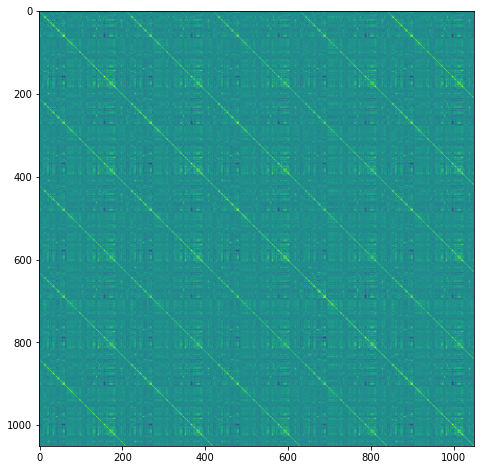

In [16]:
# The features are no longer explicit feature groups, but you can see some pretty obvious patterns if you
# visualize the feature correlation matrix. Feel free to construct your own groupings!
plt.figure(figsize = (8,8))
plt.imshow(df[df.era=='0001'][features].corr())

In [7]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [21]:
# There are 574 eras numbered from 1 to 574
eras.describe()
# df.era.count()

count    2.412105e+06
mean     3.043023e+02
std      1.598982e+02
min      1.000000e+00
25%      1.720000e+02
50%      3.040000e+02
75%      4.430000e+02
max      5.740000e+02
Name: erano, dtype: float64

<AxesSubplot:xlabel='erano'>

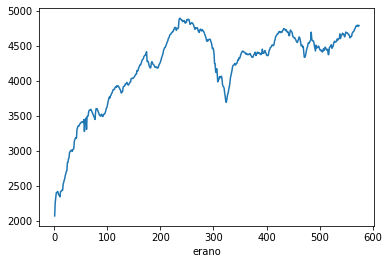

In [22]:
# The earlier eras are smaller, but generally each era is 4000-5000 rows
df.groupby(eras).size().plot()

In [8]:
# The target is discrete and takes on 5 different values with about 5% in 0 & 1, 20% in 0.75 & 0.25, and 50% in 0.50
df.groupby(target).size()/len(df)

target
0.00    0.050003
0.25    0.199996
0.50    0.499993
0.75    0.200015
1.00    0.049992
dtype: float64

In [25]:
# Some new targets have a different distribution and the bins are less rigid in the percent of samples contained
print(df.groupby('target_william_20').size()/len(df))
print()
print(df.groupby('target_arthur_20').size()/len(df))

target_william_20
0.000000    0.029735
0.166667    0.059873
0.333333    0.211150
0.500000    0.391798
0.666667    0.203550
0.833333    0.065247
1.000000    0.038511
dtype: float64

target_arthur_20
0.000000    0.028859
0.166667    0.073267
0.333333    0.258668
0.500000    0.384931
0.666667    0.173287
0.833333    0.052486
1.000000    0.028367
dtype: float64


# Some of the features are very correlated
Some even perfectly correlated within a particular era

In [26]:
feature_corrs = df[df.era=='0001'][features].corr()

In [27]:
feature_corrs.stack().head()

feature_dichasial_hammier_spawner  feature_dichasial_hammier_spawner       1.000000
                                   feature_rheumy_epistemic_prancer        0.001690
                                   feature_pert_performative_hormuz        0.141253
                                   feature_hillier_unpitied_theobromine    0.170891
                                   feature_perigean_bewitching_thruster   -0.151098
dtype: float64

In [28]:
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_calycled_living_birmingham            feature_dentilingual_removed_osmometer             -0.947381
feature_criticisable_authentical_deprecation  feature_invalid_extortionary_titillation           -0.927235
feature_hierologic_assault_candida            feature_multicostate_undescended_monoacid          -0.926623
feature_apogamic_obeisant_pondicherry         feature_splitting_sexagesimal_teutonisation        -0.923430
feature_earthlier_parian_pistachio            feature_grandmotherly_circumnavigable_homonymity   -0.913526
                                                                                                    ...   
feature_escutcheoned_timocratic_kotwal        feature_horizontal_snug_description                 1.000000
                                              feature_neptunian_supersensitive_stapler            1.000000
                                              feature_interoceptive_fifteenth_trey                1.000000
                                     

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
df.astype(dtype='float')

ValueError: could not convert string to float: 'train'

In [11]:

X = df_r[features]
# calculate the correlation matrix
corr = X.corr()
# plot set-up
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

# plot the heatmap
sns.heatmap(corr)

MemoryError: Unable to allocate 1.56 GiB for an array with shape (1050, 200000) and data type float64

### The correlation can change over time
You can see this by comparing feature correlations on the first half and second half on the training set

In [29]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [30]:
corr1 = df1[df1.era=='0001'][features].corr().unstack()
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]

In [31]:
corr2 = df2[df2.era=='0574'][features].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [32]:
tdf = pd.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
tdf.sort_values(by="corr_diff")

,,corr1,corr2,corr_diff
feature_brushed_psychiatrical_lubbock,feature_savory_engrained_undervest,1.000000,-0.159888,-1.159888
feature_interpenetrative_enabling_elm,feature_savory_engrained_undervest,1.000000,-0.159262,-1.159262
feature_horizontal_snug_description,feature_savory_engrained_undervest,1.000000,-0.158691,-1.158691
feature_abstersive_emotional_misinterpreter,feature_horizontal_snug_description,1.000000,-0.156998,-1.156998
feature_opposable_argumentative_mesoblast,feature_savory_engrained_undervest,1.000000,-0.156654,-1.156654
...,...,...,...,...
feature_descendent_decanal_hon,feature_petitionary_evanescent_diallage,0.128122,0.944659,0.816537
feature_indirect_concrete_canaille,feature_juvenalian_paunchy_uniformitarianism,-0.098432,0.727993,0.826425
feature_draconic_contractible_romper,feature_indirect_concrete_canaille,-0.098432,0.737243,0.835675
feature_bleeding_arabesque_pneuma,feature_instrumentalist_extrovert_cassini,-0.135409,0.720442,0.855851


## Some features are predictive on their own

In [14]:
feature_scores = {feature: score for feature, score in zip(features, np.corrcoef(df_r[df_r.era=='0001'][[target]+features].T)[1:,0])}

In [15]:
pd.Series(feature_scores).sort_values()

feature_voltairean_consolidative_parallel   -0.155090
feature_septicemic_telangiectatic_flake     -0.139367
feature_armoured_finable_skywriter          -0.139324
feature_literate_treacly_altercation        -0.125702
feature_tittering_virgilian_decliner        -0.117656
                                               ...   
feature_cheering_protonemal_herd             0.111927
feature_aggrieved_rammish_tommy              0.118310
feature_flavourful_seismic_erica             0.123199
feature_axillary_reluctant_shorty            0.134004
feature_submediant_serbonian_rangefinder     0.143034
Length: 1050, dtype: float64

<AxesSubplot:>

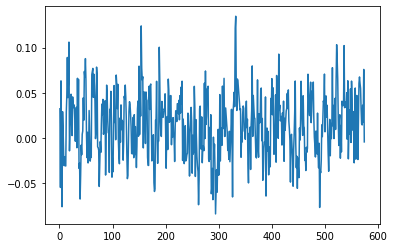

In [16]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf[target], tdf["feature_grandmotherly_circumnavigable_homonymity"])[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot()

<AxesSubplot:>

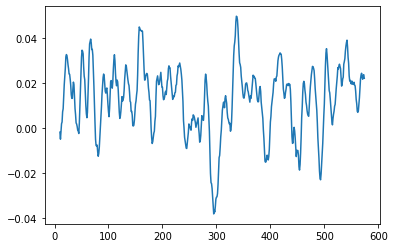

In [21]:
# With a rolling 10 era average you can see some trends
by_era_correlation.rolling(10).mean().plot()

## The feature exposures of different targets can be very different, even orthogonal

In [17]:
feature_scores_nomi20 = {feature: score for feature, score in zip(features, np.corrcoef(df_r[df_r.era=='0001'][['target_nomi_20']+features].T)[1:,0])}

In [18]:
feature_scores_nomi60 = {feature: score for feature, score in zip(features, np.corrcoef(df_r[df_r.era=='0001'][['target_nomi_60']+features].fillna(0.5).T)[1:,0])}

0.5211320866734157


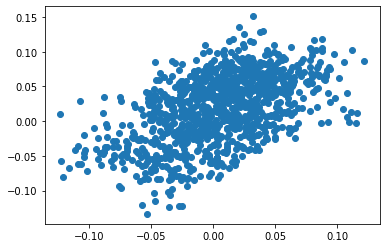

In [22]:
plt.scatter(feature_scores_nomi20.values(), feature_scores_nomi60.values())
print(np.corrcoef(list(feature_scores_nomi20.values()), list(feature_scores_nomi60.values()))[0,1])

In [19]:
feature_scores_jerome = {feature: score for feature, score in zip(features, np.corrcoef(df_r[df_r.era=='0001'][['target_jerome_20']+features].T)[1:,0])}

In [20]:
feature_scores_janet = {feature: score for feature, score in zip(features, np.corrcoef(df_r[df_r.era=='0001'][['target_janet_20']+features].T)[1:,0])}

0.1510121049141406


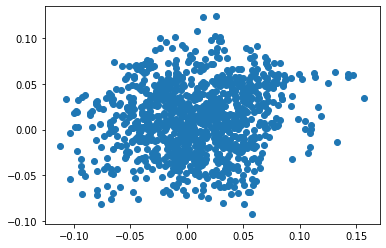

In [26]:
plt.scatter(feature_scores_jerome.values(), feature_scores_janet.values())
print(np.corrcoef(list(feature_scores_jerome.values()), list(feature_scores_janet.values()))[0,1])

# Gotcha: MSE looks worse than correlation out of sample
Models will generally be overconfident, so even if they are good at ranking rows, the Mean-Squared-Error of the residuals could be larger than even the Mean-Squared-Error of the target (r-squared<0)

In [21]:
df1 = df_r[eras<=eras.median()]
df2 = df_r[eras>eras.median()]

In [22]:
linear1 = linear_model.LinearRegression()
linear1.fit(df1[features], df1[target])
linear2 = linear_model.LinearRegression()
linear2.fit(df2[features], df2[target])

LinearRegression()

In [29]:
# Note in particular that the R-squared of (train_on_1, eval_on_2) is slightly negative!
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.010403,-0.004193
train_on_2,-0.004020,0.009701


In [30]:
# Note in particular that the correlation of (train_on_1, eval_on_2) is quite decent
corrs = [
    [
        numerai_score(dfX[target], pd.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.098994,0.029206
train_on_2,0.031705,0.094462


In [34]:
# This can be be run with LightGBM as well

In [31]:
lgb1 = lightgbm.LGBMRegressor()
lgb1.fit(df1[features], df1[target])
lgb2 = lightgbm.LGBMRegressor()
lgb2.fit(df2[features], df2[target])

LGBMRegressor()

In [32]:
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [lgb1, lgb2]
]
pd.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.050527,-0.000202
train_on_2,-0.000043,0.052082


In [33]:
corrs = [
    [
        numerai_score(dfX[target], pd.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [lgb1, lgb2]
]
pd.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.309456,0.034768
train_on_2,0.036272,0.311440


# Gotcha: Eras are now overlapping!

Eras are weekly (5 days), but the target is four weeks out (20 days). You can subsample the eras (every 4th era) to prevent models from overfitting due to overlapping eras. You can then ensemble the models trained on each of the 4 different ways to subsample.

In [23]:
# train model on all eras in df1
lgb_all = lightgbm.LGBMRegressor()
lgb_all.fit(df1[features], df1[target])

LGBMRegressor()

In [45]:
lgb_all.feature_name_

['feature_dichasial_hammier_spawner',
 'feature_rheumy_epistemic_prancer',
 'feature_pert_performative_hormuz',
 'feature_hillier_unpitied_theobromine',
 'feature_perigean_bewitching_thruster',
 'feature_renegade_undomestic_milord',
 'feature_koranic_rude_corf',
 'feature_demisable_expiring_millepede',
 'feature_unscheduled_malignant_shingling',
 'feature_clawed_unwept_adaptability',
 'feature_rubblier_chlorotic_stogy',
 'feature_untumbled_histologic_inion',
 'feature_piffling_inflamed_jupiter',
 'feature_abstersive_emotional_misinterpreter',
 'feature_unluckiest_mulley_benzyl',
 'feature_escutcheoned_timocratic_kotwal',
 'feature_integrated_extroversive_ambivalence',
 'feature_vedic_mitral_swiz',
 'feature_reclaimed_fallibilist_turpentine',
 'feature_gone_honduran_worshipper',
 'feature_insociable_exultant_tatum',
 'feature_outdated_tapered_speciation',
 'feature_leggiest_slaggiest_inez',
 'feature_chaldean_vixenly_propylite',
 'feature_hysteric_mechanized_recklinghausen',
 'feature_g

In [24]:
# train models on subsamples eras in df1
lgb1 = lightgbm.LGBMRegressor()
lgb1.fit(df1[eras.isin(np.arange(1, 304, 4))][features], df1[eras.isin(np.arange(1, 304, 4))][target])

lgb2 = lightgbm.LGBMRegressor()
lgb2.fit(df1[eras.isin(np.arange(2, 304, 4))][features], df1[eras.isin(np.arange(2, 304, 4))][target])

lgb3 = lightgbm.LGBMRegressor()
lgb3.fit(df1[eras.isin(np.arange(3, 304, 4))][features], df1[eras.isin(np.arange(3, 304, 4))][target])

lgb4 = lightgbm.LGBMRegressor()
lgb4.fit(df1[eras.isin(np.arange(4, 304, 4))][features], df1[eras.isin(np.arange(4, 304, 4))][target])

/tmp/ipykernel_128009/3774019056.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb1.fit(df1[eras.isin(np.arange(1, 304, 4))][features], df1[eras.isin(np.arange(1, 304, 4))][target])
/tmp/ipykernel_128009/3774019056.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb1.fit(df1[eras.isin(np.arange(1, 304, 4))][features], df1[eras.isin(np.arange(1, 304, 4))][target])
/tmp/ipykernel_128009/3774019056.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb2.fit(df1[eras.isin(np.arange(2, 304, 4))][features], df1[eras.isin(np.arange(2, 304, 4))][target])
/tmp/ipykernel_128009/3774019056.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb2.fit(df1[eras.isin(np.arange(2, 304, 4))][features], df1[eras.isin(np.arange(2, 304, 4))][target])
/tmp/ipykernel_128009/3774019056.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb

LGBMRegressor()

In [25]:
# calculate predictions for each model
preds = [
        pd.Series(model.predict(df2[features]), index=df2.index)
    for model in [lgb_all, lgb1, lgb2, lgb3, lgb4]
]

In [28]:
# numerai score of model trained on all eras of df1
numerai_score(df2[target], preds[0])

0.042100636854863906

In [29]:
# numerai score of ensemble of models trained on all subsampled eras of df1
numerai_score(df2[target], pd.concat(preds, axis=1)[[1,2,3,4]].mean(axis=1))

0.04417881399166067

# Gotcha: eras are homogenous, but different from each other
##  Random cross-validation will look much better than cross-validating by era

Even for a simple linear model, taking a random shuffle reports a correlation of ~5.1%, but a time series split reports a lower score of ~2.6%

# Gotcha: Eras are now overlapping!
##  Even era-wise cross-validation will now have leakage!
Eras are weekly (5 days), but the target is four weeks out (20 days). You can either use blocks of eras and purge the overlapping sections or subsample the eras (every 4th era) to make them not overlapping and prevent leakage

In [42]:
# Subsample data to every 4th era to prevent overlapping eras
df = df[eras.isin(np.arange(1, 575, 4))]
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [43]:
eras = eras[eras.isin(np.arange(1, 575, 4))]

In [ ]:
df1.nan_to_num(X)
df2.nan_to_num(X)
df1.dropna()
df1.dropna()

In [45]:
#Now we have two dataframes, and need to define X, y and era twice. Let's do that now.
#kopie Cross_validation notebook [38]


X_train = df1[features].values

X_test = df2[features].values

y_train = df1.target_jerome_20.values

y_test = df2.target_jerome_20.values

era_train = df1.era.values

era_test = df2.era.values

In [47]:
df1.fillna(df1.mean(), inplace=True)
df2.fillna(df2.mean(), inplace=True)

/tmp/ipykernel_92993/2722149778.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1.fillna(df1.mean(), inplace=True)
/tmp/ipykernel_92993/2722149778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.fillna(df1.mean(), inplace=True)
/tmp/ipykernel_92993/2722149778.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df2.fillna(df2.mean(), inplace=True)
/tmp/ipykernel_92993/2722149778.py:2: SettingWithCopy

In [48]:
#import the model_selection module

from sklearn import model_selection

#define your cross-validation iterator

CV = model_selection.GroupKFold(n_splits = 5)

In [49]:
#We can now define a new variable which stores these row identifiers for algorithms to use.

grp = list(CV.split(X = X_train, y = y_train,  groups = era_train))

#what this line does is:

#1 - define a new variable: grp = 
#2 - use the python 'list' function: list(
#3 - within the list function, we use the .split() method on our group k-fold iterator, which we defined as CV: CV.split(
#4 - within the .split() method, we defined the required parameters and closed the .split parenthesis: X = X_train, y = y_train, groups = era_train)
#5 - we enclosed the list function: )

#this is called nested function.

In [14]:
check_nan_in_df = df1.isnull()
print (check_nan_in_df)

                    era  data_type  feature_dichasial_hammier_spawner  \
id                                                                      
n003bba8a98662e4  False      False                              False   
n003bee128c2fcfc  False      False                              False   
n0048ac83aff7194  False      False                              False   
n00691bec80d3e02  False      False                              False   
n00b8720a2fdc4f2  False      False                              False   
...                 ...        ...                                ...   
nffca5ac25673dd8  False      False                              False   
nffd52bb5dd6afba  False      False                              False   
nffed72498a8e3a9  False      False                              False   
nfff95e6328556f7  False      False                              False   
nfffd7597bd23140  False      False                              False   

                  feature_rheumy_epistemic_prancer

[301127 rows x 1074 columns]


In [34]:
pd.set_option('use_inf_as_na', True)

In [36]:
df1.replace([np.inf, -np.inf], np.nan)
df2.replace([np.inf, -np.inf], np.nan)

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60,erano
id,,,,,,,,,,,,,,,,,,,,,
n000381ad0c8af9b,0305,train,0,3,1,3,1,3,3,0,...,0.50,0.50,0.25,0.666667,0.500000,0.500000,0.500000,0.500000,0.500000,305
n000ac54b6e92b06,0305,train,1,2,1,2,1,2,4,1,...,0.75,0.75,0.50,0.833333,0.666667,0.666667,0.666667,0.500000,0.500000,305
n002da3f2943306f,0305,train,3,1,3,3,2,2,3,4,...,0.50,0.50,0.50,0.666667,0.666667,0.500000,0.500000,0.500000,0.500000,305
n003ce01108ee7fe,0305,train,3,2,4,2,1,4,2,3,...,0.50,0.50,0.50,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,305
n004a5425ef72d68,0305,train,4,0,4,0,0,0,4,3,...,0.50,0.50,0.50,0.833333,0.666667,0.666667,0.666667,0.500000,0.500000,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc2d5e4b79a7ae,0573,train,1,2,3,2,3,2,2,1,...,0.50,0.00,0.50,0.166667,0.500000,0.166667,0.333333,0.333333,0.333333,573
nffc7d24176548a4,0573,train,4,2,3,4,2,0,3,2,...,0.25,0.50,0.25,0.500000,0.333333,0.500000,0.333333,0.500000,0.333333,573
nffc9844c1c7a6a9,0573,train,4,3,3,4,1,1,3,3,...,0.75,0.50,0.50,0.333333,0.500000,0.333333,0.500000,0.500000,0.500000,573


In [29]:
df1.isna().sum()

era                                     0
data_type                               0
feature_dichasial_hammier_spawner       0
feature_rheumy_epistemic_prancer        0
feature_pert_performative_hormuz        0
                                     ... 
target_arthur_20                       62
target_arthur_60                     3280
target_thomas_20                        0
target_thomas_60                     2490
erano                                   0
Length: 1074, dtype: int64

In [50]:
from sklearn import linear_model
alphas = (0.1, 0.5, 1.0, 10.0)
REG1 = linear_model.RidgeCV(alphas = alphas, cv = grp)
REG1.fit(X_train, y_train)

/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py", line 1003, in fit
    X, y = self._validate_data(
  File "/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/base.py", line 581, in _validate_data
   

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [9]:
# Because the TimeSeriesSplit class in sklearn does not use groups and won't respect era boundries, we implement
# a version that will

from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples

class TimeSeriesSplitGroups(_BaseKFold):
    def __init__(self, n_splits=5):
        super().__init__(n_splits, shuffle=False, random_state=None)

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_list = np.unique(groups)
        n_groups = len(group_list)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_groups))
        indices = np.arange(n_samples)
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        test_starts = list(test_starts)[::-1]
        for test_start in test_starts:
            
            yield (indices[groups.isin(group_list[:test_start])],
                   indices[groups.isin(group_list[test_start:test_start + test_size])])


In [10]:
crossvalidators = [
    model_selection.KFold(5),
    model_selection.KFold(5, shuffle=True),
    model_selection.GroupKFold(5),
    TimeSeriesSplitGroups(5)
]

In [11]:
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [ ]:
for cv in crossvalidators:
    print(cv)
    print(np.mean(
            model_selection.cross_val_score(
            linear_model.LinearRegression(),
            df[features],
            df[target],
            cv=cv,
            n_jobs=1,
            groups=eras,
            scoring=metrics.make_scorer(correlation_score, greater_is_better=True)
        )))
    print()

KFold(n_splits=5, random_state=None, shuffle=False)


# Gotcha:  {0, 1} are noticeably different from {0.25, 0.75}
This makes training a classifier one-versus-rest behave counterintuitively.

Specifically, a multinomial classifier seem to learn how to pick out extreme targets, and their predictions are the most correlated

In [104]:
# Train a standard logistic regression as a classifier
logistic = linear_model.LogisticRegression(multi_class='multinomial', solver='saga')
logistic.fit(df1[features], (df1[target]*4).astype(int))
logistic.score(df1[features], (df1[target]*4).astype(int))

/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.4997027832110704

array([[ 1.        ,  0.33340721, -0.83285677,  0.27459881,  0.75232883],
       [ 0.33340721,  1.        , -0.58463168,  0.17494748,  0.21275609],
       [-0.83285677, -0.58463168,  1.        , -0.62027599, -0.83121278],
       [ 0.27459881,  0.17494748, -0.62027599,  1.        ,  0.37187111],
       [ 0.75232883,  0.21275609, -0.83121278,  0.37187111,  1.        ]])

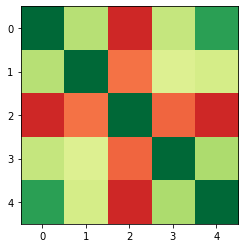

In [105]:
# The first and last class are highly correlated
corrs=np.corrcoef(logistic.predict_proba(df2[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

In [106]:
# Out-of-sample correlation is 3.5%
preds = pd.Series(logistic.predict_proba(df2[features]).dot(logistic.classes_), index=df2.index)
numerai_score(df2[target], preds)

0.034821680070081934

In [107]:
# A standard linear model has a slightly lower correlation out-of-sample
linear = linear_model.LinearRegression()
linear.fit(df1[features], df1[target])
linear.score(df2[features], df2[target])
preds = pd.Series(linear.predict(df2[features]), index=df2.index)
numerai_score(df2[target], preds)

0.03469890516866748

## Eras can be more or less applicable to other eras
You can test this be splitting the eras into blocks of 15, training on each block, and evaluating on each other block.

In [108]:
# convert the subsampled era labels to continuous integers
eras_sub = (eras-1)//4

In [109]:
eras15 = (eras_sub // 15) * 15
eras15.value_counts()

60     71000
105    69251
120    67610
45     67268
90     66300
75     61933
30     61333
15     54214
0      42920
135    42282
Name: erano, dtype: int64

In [111]:
results15 = []
for train_era, tdf in df.groupby(eras15):
    print(train_era)
    model = linear_model.LinearRegression()
    model.fit(tdf[features], tdf[target])
    for test_era, tdf in df.groupby(eras15):
        results15.append([
            train_era,
            test_era,
            correlation_score(tdf[target], model.predict(tdf[features]))
        ])

0
15
30
45
60
75
90
105
120
135


In [112]:
results_df = pd.DataFrame(
    results15,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

test_era,0,15,30,45,60,75,90,105,120,135
train_era,,,,,,,,,,
0,0.194912,-0.005616,0.002637,-0.000948,-0.005057,-0.001581,-0.002018,0.002041,-0.001608,-0.003278
15,0.046597,0.170731,0.029354,-0.002530,-0.000635,0.000452,0.005381,-0.004351,0.002867,-0.000605
30,0.039442,0.032834,0.156106,0.001567,-0.000632,-0.002577,-0.006966,0.005070,-0.002746,0.001488
45,0.023706,0.030027,0.035148,0.148862,0.010267,0.021071,0.027580,0.015904,0.031235,0.023599
60,0.012483,0.006499,0.009025,0.016631,0.149721,0.019196,0.010640,0.013178,0.010896,0.011191
75,0.025632,0.018699,0.031269,0.016043,0.018465,0.166712,0.026355,0.017058,0.021476,0.011319
90,0.044773,0.025483,0.024667,0.024288,0.005159,0.029021,0.153414,0.024905,0.021045,0.016773
105,0.029213,0.027908,0.018279,0.012079,0.008206,0.016061,0.027251,0.143886,0.023365,0.009489
120,0.033693,0.036589,0.018515,0.030187,0.007597,0.026739,0.023073,0.028707,0.144769,0.030703


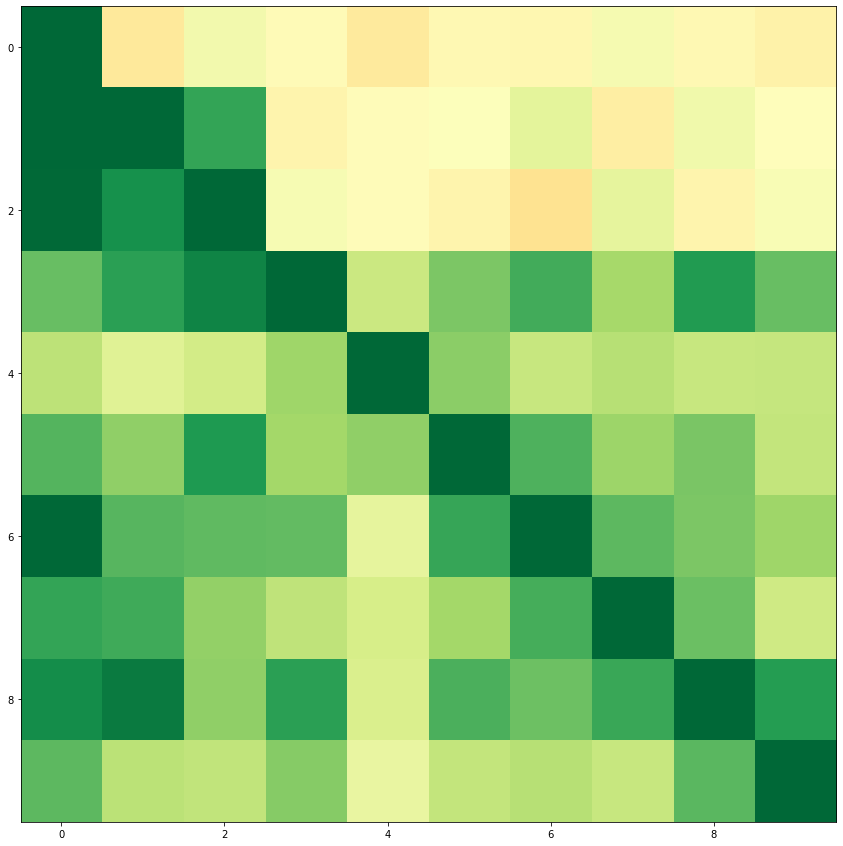

In [113]:
# Each row here is the training block of eras, each column is a testing block of eras.
# Note that there is a period in the early groups that does not seem to be relevant to other eras, and the
# overall performance seems to decrease a bit over time.
plt.figure(figsize=(15,15))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")

Here is an advanced paper that talks about generalization.
Eras can be thought about in the same way that "distributions" or "environments" are talked about here
https://arxiv.org/pdf/1907.02893.pdf

## Gotcha: Since the signal-to-noise ratio is so low, models can take many more iterations than expected, and have scarily high in-sample performance

In [114]:
def our_score(preds, dtrain):
    return "score", -np.corrcoef(preds, dtrain.get_label())[0,1], False

df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [115]:
dtrain = lightgbm.Dataset(df1[features], df1[target])
dtest = lightgbm.Dataset(df2[features], df2[target])
dall = lightgbm.Dataset(df[features], df[target])

/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.825171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5250
[LightGBM] [Info] Number of data points in the train set: 305247, number of used features: 1050
[LightGBM] [Info] Start training from score 0.499998
[20]	train's l2: 0.0498386	train's score: -0.0696572	test's l2: 0.0499211	test's score: -0.042272
[40]	train's l2: 0.0497466	train's score: -0.0845498	test's l2: 0.0499021	test's score: -0.0449487
[60]	train's l2: 0.0496736	train's score: -0.0950992	test's l2: 0.049894	test's score: -0.0462429
[80]	train's l2: 0.0496094	train's score: -0.103748	test's l2: 0.0498883	test's score: -0.0474028
[100]	train's l2: 0.0495503	train's score: -0.111415	test's l2: 0.049883	test's score: -0.0485958
[120]	train's l2: 0.0494963	train's score: -0.118318	test's l2: 0.0498832	test's score: -0.0487773
[140]	train's l2: 0.0494427	train's score: -0.124419	test's l2

<AxesSubplot:>

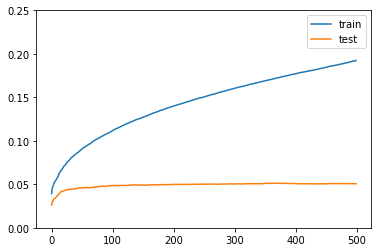

In [116]:
param = {
    'max_depth':3,
    'eta':0.1,
    'objective':'regression',
    'metric':'mse',
    'nthread': -1,
}
evals_result = {}
bst = lightgbm.train(
    params=param,
    train_set=dtrain,
    feval=our_score,
    num_boost_round=500,
    valid_sets=[dtrain, dtest],
    valid_names=['train', 'test'],
    evals_result=evals_result,
    verbose_eval=20,
)

(-pd.DataFrame({k: v['score'] for k,v in evals_result.items()})).plot(ylim=[0,0.25])

# The results are sensitive to the choice of parameters, which should be picked through cross-validation

In [7]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [8]:
models = [
    linear_model.LinearRegression(),
] + [
    linear_model.ElasticNet(alpha=alpha)
    for alpha in [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001]
] + [
    lightgbm.LGBMRegressor(n_jobs=-1),
    lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=600),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=600),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=300, max_depth=5),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.001, n_estimators=300, max_depth=5),
]

In [9]:
for model in models:
    print(" -- ", model)   
    model.fit(df1[features], df1[target])
    outsample = numerai_score(df2[target], pd.Series(model.predict(df2[features]), index=df2.index))
    insample = numerai_score(df1[target], pd.Series(model.predict(df1[features]), index=df1.index))
    print(
        f"outsample: {outsample}, insample: {insample}"
    )
    print()

 --  LinearRegression()
outsample: 0.037630665987238784, insample: 0.0818882351441888

 --  ElasticNet(alpha=0.01)
outsample: 0.02465964740612436, insample: 0.03214147307436695

 --  ElasticNet(alpha=0.005)
outsample: 0.03691560482738873, insample: 0.04894157968342135

 --  ElasticNet(alpha=0.002)
outsample: 0.043074978685822385, insample: 0.06094062544711397

 --  ElasticNet(alpha=0.001)
outsample: 0.04449992085387888, insample: 0.0674467522545089

 --  ElasticNet(alpha=0.0005)
outsample: 0.043965690481420704, insample: 0.07155680192020843

 --  ElasticNet(alpha=0.0002)
outsample: 0.04210980675060572, insample: 0.07722858915144301

 --  ElasticNet(alpha=0.0001)


/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.645e+01, tolerance: 6.043e+00
  model = cd_fast.enet_coordinate_descent(


outsample: 0.040371760683154255, insample: 0.0800985482458065

 --  ElasticNet(alpha=5e-05)


/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.781e+02, tolerance: 6.043e+00
  model = cd_fast.enet_coordinate_descent(


outsample: 0.039172499165090656, insample: 0.08133767504574355

 --  ElasticNet(alpha=2e-05)


/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.028e+03, tolerance: 6.043e+00
  model = cd_fast.enet_coordinate_descent(


outsample: 0.038327611534411304, insample: 0.0817924577801703

 --  ElasticNet(alpha=1e-05)


/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.715e+03, tolerance: 6.043e+00
  model = cd_fast.enet_coordinate_descent(


outsample: 0.03801470380318886, insample: 0.08187114995322652

 --  LGBMRegressor()
outsample: 0.04710080326547761, insample: 0.19282716278047016

 --  LGBMRegressor(learning_rate=0.01, n_estimators=600)
outsample: 0.04881140826892164, insample: 0.1673920826169473

 --  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, n_estimators=600)
outsample: 0.05122975710911491, insample: 0.15476393692311702

 --  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=300)
outsample: 0.04935690883789484, insample: 0.11534809586854712

 --  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.001, max_depth=5,
              n_estimators=300)
outsample: 0.04591506013507559, insample: 0.09140856861854056



## Gotcha: Models with large exposures to individual features tend to perform poorly or inconsistently out of sample ## 


In [6]:
import numpy as np
import scipy

In [ ]:
# Train a standard xgboost on half the train eras
lgb = lightgbm.LGBMRegressor(n_estimators=800, max_depth=5, learning_rate=0.01, n_jobs=-1)
lgb.fit(df_r[features], df_r[target])
lgb_preds = lgb.predict(df_r[features])
df_tour['prediction'] =  lgb.predict(df_tour[features])

In [ ]:
# Instantiate Numerai API again but with API keys for submission
PUBLIC_KEY = ''
PRIVATE_KEY = ''

napi = NumerAPI(PUBLIC_KEY, PRIVATE_KEY)
current_round = napi.get_current_round()
print("ROUND NUMBER: ", current_round)

In [ ]:
# Format prediction CSV for submission
prediction_df = df_tour.reset_index()[['id', 'prediction']]
prediction_df[['id', 'prediction']].to_csv(f'round{current_round}_tour_model_LGBM800_predictions.csv', index=False) # Important to name your CSV file so you know wh

In [ ]:
model_id = ''
napi.upload_predictions(f'round{current_round}_tour_model_LGBM800_predictions.csv', model_id=model_id, version=2)

### Our predictions have correlation < -0.4 and > 0.20 for some single features!
Sure hope those features continue to act as they have in the past!

In [54]:
corr_list = []
for feature in features:
    corr_list.append(np.corrcoef(df2[feature], lgb_preds)[0,1])
corr_series = pd.Series(corr_list, index=features)
corr_series.describe()

count    1050.000000
mean        0.007919
std         0.086043
min        -0.488450
25%        -0.050563
50%         0.004352
75%         0.073155
max         0.195427
dtype: float64

In [55]:
from sklearn.preprocessing import MinMaxScaler
import scipy

def neutralize(df,
               columns,
               neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        print(u, end="\r")
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed),
                        columns=columns,
                        index=df.index)

In [56]:
df2["preds"] = lgb_preds
df2["preds_neutralized"] = neutralize(df2, 
                                      columns=["preds"], 
                                      neutralizers=features, 
                                      proportion=0.5, # neutralize by 50% within each era
                                      normalize=True,
                                      era_col='era') 

scaler = MinMaxScaler()
df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]]) # transform back to 0-1

/tmp/ipykernel_128009/935681447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"] = lgb_preds


/tmp/ipykernel_128009/935681447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized"] = neutralize(df2,
/tmp/ipykernel_128009/935681447.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]]) # transform back to 0-1


### Now our single feature exposures are much smaller

In [57]:
corr_list2 = []
for feature in features:
    corr_list2.append(np.corrcoef(df2[feature], df2["preds_neutralized"])[0,1])
corr_series2 = pd.Series(corr_list2, index=features)

In [58]:
corr_series2.describe()

count    1050.000000
mean        0.000433
std         0.003731
min        -0.010527
25%        -0.001993
50%         0.000306
75%         0.003015
max         0.009866
dtype: float64

### Our overall score goes down, but the scores are more consistent than before. This leads to a higher sharpe

In [59]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

score for high feature exposure: 0.04059671215122932
score for balanced feature expo: -0.002621956015393881
std for high feature exposure: 0.032396624682988
std for balanced feature expo: 0.02529778615357758
sharpe for high feature exposure: 1.2531154880634008
sharpe for balanced feature expo: -0.10364369433263974


In [50]:
balanced_scores_per_era.describe()

count    10.000000
mean      0.039004
std       0.023533
min       0.013010
25%       0.018847
50%       0.036098
75%       0.051287
max       0.088303
dtype: float64

In [51]:
unbalanced_scores_per_era.describe()

count    10.000000
mean      0.049952
std       0.023057
min       0.021632
25%       0.034473
50%       0.048814
75%       0.055055
max       0.101719
dtype: float64

## We can also try to be more clever about what features we neutralize
### The "riskiest" features are the features the predictions are most exposed to that also have the highest volatility 

In [122]:
# compute feature correlations with target on the first half data
all_feature_corrs = df1.groupby('era').apply(lambda d: d[features].corrwith(d[target]))
# compute the volatility of the feature correlations
feature_corr_volatility = all_feature_corrs.std()

In [61]:
# calculate the feature exposures of the predictions
feature_exposure_list = []
for feature in features:
    feature_exposure_list.append(np.corrcoef(df2[feature], lgb_preds)[0,1])
feature_exposure_list = pd.Series(feature_exposure_list, index=features)

In [62]:
# get list of 100 riskiest features
riskiest_features = (feature_exposure_list.abs()*feature_corr_volatility).sort_values()[-100:].index.tolist()

In [63]:
# 50% neutralize to the riskiest features
df2["preds_neutralized_riskiest_100"] = neutralize(df2, 
                                                  columns=["preds"], 
                                                  neutralizers=riskiest_features, 
                                                  proportion=0.5, # 50% neutralize only those 100 features
                                                  normalize=True, 
                                                  era_col='era')

scaler = MinMaxScaler()
df2["preds_neutralized_riskiest_100"] = scaler.fit_transform(df2[["preds_neutralized_riskiest_100"]]) # transform back to 0-1

/tmp/ipykernel_128009/1405235807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized_riskiest_100"] = neutralize(df2,
/tmp/ipykernel_128009/1405235807.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized_riskiest_100"] = scaler.fit_transform(df2[["preds_neutralized_riskiest_100"]]) # transform back to 0-1


In [ ]:
### The score goes down less and the sharpe goes up more than 50% neutralizing all the features

In [64]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized_riskiest_100"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

score for high feature exposure: 0.04059671215122932
score for balanced feature expo: -0.0019553205040556006
std for high feature exposure: 0.032396624682988
std for balanced feature expo: 0.02543936565992191
sharpe for high feature exposure: 1.2531154880634008
sharpe for balanced feature expo: -0.07686199924143874


In [ ]:
### Interestingly, the maximal feature exposure magnitude is actually lower (~0.28 vs ~0.31) than when 50% neutralizing all features

In [65]:
corr_list3 = []
for feature in features:
    corr_list3.append(np.corrcoef(df2[feature], df2["preds_neutralized_riskiest_100"])[0,1])
corr_series3 = pd.Series(corr_list3, index=features)
corr_series3.describe()

count    1050.000000
mean        0.000587
std         0.003425
min        -0.009773
25%        -0.001714
50%         0.000619
75%         0.002998
max         0.008517
dtype: float64

In [58]:
corr_series3.describe()

count    1050.000000
mean        0.004331
std         0.056821
min        -0.354841
25%        -0.017705
50%         0.009367
75%         0.042633
max         0.107308
dtype: float64

# Training on the alternative targets can result in models with different patterns of feature exposures
## This is a great way to go after MMC and very useful for ensembling

In [123]:
lgb = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=200, max_depth=5)
lgb.fit(df[features], df['target'])

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=200)

In [67]:
lgb_jerome = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=200, max_depth=5)
lgb_jerome.fit(df1[features], df1['target_jerome_20'])

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=200)

In [84]:
# The feature importances for each model are about 63% correlated

0.49074185248971


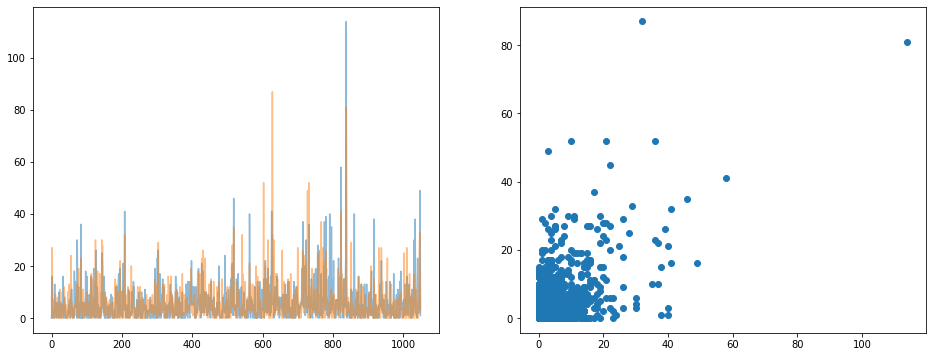

In [68]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(lgb.feature_importances_, alpha=.5)
plt.plot(lgb_jerome.feature_importances_, alpha=.5)
plt.subplot(1,2,2)
plt.scatter(lgb.feature_importances_, lgb_jerome.feature_importances_)

print(np.corrcoef([lgb.feature_importances_, lgb_jerome.feature_importances_])[0,1])

In [ ]:
df_tour['prediction'] = lgb.predict(df_tour[features])

In [69]:
lgb_preds = lgb.predict(df2[features])
df2['prediction'] = lgb.predict(df2[features])
lgb_jerome_preds = lgb_jerome.predict(df2[features])

/tmp/ipykernel_128009/3114868341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['prediction'] = lgb.predict(df2[features])


In [70]:
# The predictions are about 75% correlated
np.corrcoef([lgb_preds, lgb_jerome_preds])[0,1]

0.6103187129906299

In [71]:
df2["preds"] = lgb_preds
df2["preds_jerome"] = lgb_jerome_preds

/tmp/ipykernel_128009/3387032128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"] = lgb_preds
/tmp/ipykernel_128009/3387032128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_jerome"] = lgb_jerome_preds


In [72]:
# 50% neutralize to riskest features for each model as above
for preds in ["preds", "preds_jerome"]:
    feature_exposure_list = []
    for feature in features:
        feature_exposure_list.append(np.corrcoef(df2[feature], df2[preds])[0,1])
    feature_exposure_list = pd.Series(feature_exposure_list, index=features)

    riskiest_features = (feature_exposure_list.abs()*feature_corr_volatility).sort_values()[-100:].index.tolist()
    
    df2[f"{preds}_neutralized_riskiest_100"] = neutralize(df2, 
                                                  columns=[f"{preds}"], 
                                                  neutralizers=riskiest_features, 
                                                  proportion=0.5, # 50% neutralize only those 100 features
                                                  normalize=True, 
                                                  era_col='era')

/tmp/ipykernel_128009/516990135.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[f"{preds}_neutralized_riskiest_100"] = neutralize(df2,


/tmp/ipykernel_128009/516990135.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[f"{preds}_neutralized_riskiest_100"] = neutralize(df2,


In [74]:
# create ensemble
df2["preds_ens"] = (df2["preds"] + df2["preds_jerome"])/2

/tmp/ipykernel_128009/271823728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_ens"] = (df2["preds"] + df2["preds_jerome"])/2


In [68]:
df2.head()

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_thomas_20,target_thomas_60,erano,preds,preds_neutralized,preds_neutralized_riskiest_100,prediction,preds_jerome,preds_jerome_neutralized_riskiest_100,preds_ens
id,,,,,,,,,,,,,,,,,,,,,
n0005d92998b0cb0,0057,train,2,4,2,1,1,1,4,2,...,0.500000,0.500000,57,0.496009,0.486659,0.017457,0.496009,0.522948,2.187106,0.509478
n00116b2a93dfe2c,0057,train,0,1,3,0,0,3,1,4,...,0.666667,1.000000,57,0.507688,0.596269,1.440126,0.507688,0.508690,1.534715,0.508189
n00178ea4760915e,0057,train,4,2,1,1,2,1,1,3,...,0.500000,0.833333,57,0.542982,0.788381,2.519558,0.542982,0.482299,-2.216420,0.512641
n00282891b8fe467,0057,train,2,2,2,4,0,4,4,1,...,0.500000,0.500000,57,0.494035,0.442173,-0.301391,0.494035,0.489146,-0.816943,0.491591
n00366beef070aff,0057,train,3,1,0,0,3,2,1,3,...,0.500000,0.666667,57,0.514169,0.670686,1.203583,0.514169,0.516557,1.266383,0.515363


In [79]:
# Instantiate Numerai API again but with API keys for submission
PUBLIC_KEY = ''
PRIVATE_KEY = ''

napi = NumerAPI(PUBLIC_KEY, PRIVATE_KEY)
current_round = napi.get_current_round()
print("ROUND NUMBER: ", current_round)

ROUND NUMBER:  311


In [ ]:
# Format prediction CSV for submission
prediction_df_tour = df_tour.reset_index()[['id', 'prediction']]
prediction_df_tour[['id', 'prediction']].to_csv(f'round{current_round}_LGBM_model_analysis_predictions_2.csv', index=False) # Important to name your CSV file so you know wh

In [ ]:

model_id = ''
napi.upload_predictions(f'round{current_round}_LGBM_model_analysis_predictions_2.csv', model_id=model_id, version=2)

In [75]:
scores = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
scores_jerome = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome"], d[target])[0,1])

scores_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized_riskiest_100"], d[target])[0,1])
scores_jerome_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome_neutralized_riskiest_100"], d[target])[0,1])

scores_ens = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_ens"], d[target])[0,1])

print(f"score for target: {scores.mean()}")
print(f"score for target_jerome: {scores_jerome.mean()}")
print()
print(f"sharpe for target: {scores.mean()/scores.std(ddof=0)}")
print(f"sharpe for target_jerome: {scores_jerome.mean()/scores_jerome.std(ddof=0)}")
print()
print(f"score for target after neutralization: {scores_derisked.mean()}")
print(f"score for target_jerome after neutralization: {scores_jerome_derisked.mean()}")
print()
print(f"sharpe for target after neutralization: {scores_derisked.mean()/scores_derisked.std(ddof=0)}")
print(f"sharpe for target_jerome after neutralization: {scores_jerome_derisked.mean()/scores_jerome_derisked.std(ddof=0)}")
print()
print(f"score for target + target_jerome ensemble: {scores_ens.mean()}")
print(f"sharpe for target + target_jerome ensemble: {scores_ens.mean()/scores_ens.std(ddof=0)}")


score for target: 0.03794419235988162
score for target_jerome: 0.037361836120413924

sharpe for target: 1.1799963246438032
sharpe for target_jerome: 1.0683288251245577

score for target after neutralization: -0.0016292317491581121
score for target_jerome after neutralization: 0.0029890034749074207

sharpe for target after neutralization: -0.06573928366776616
sharpe for target_jerome after neutralization: 0.10798966931027242

score for target + target_jerome ensemble: 0.042022744884372625
sharpe for target + target_jerome ensemble: 1.2320681210947548


## We see here that the model trained on `target_jerome` actually predicts `target` slightly better than the model trained on `target` (albeit with a lower Sharpe) both before and after neutralization of the riskiest features

In [105]:
# calculate correlation of neutralized predictions
df2[[f"preds_neutralized_riskiest_100", f"preds_jerome_neutralized_riskiest_100"]].corr()

,preds_neutralized_riskiest_100,preds_jerome_neutralized_riskiest_100
preds_neutralized_riskiest_100,1.000000,0.661828
preds_jerome_neutralized_riskiest_100,0.661828,1.000000


## Given that the neutralized version trained on `target_jerome` gets slightly better average score, but is only about 67% correlated with the neutralized version trained on `target`, it is an excellent candidate for MMC
## However, ensembling the two neutralized predictions gives a model with the highest average score and a great Sharpe value